### Importing Libraries

In [295]:
import pandas as pd
import numpy as np


from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.metrics import accuracy_score, confusion_matrix


#Classifiers
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.naive_bayes import ComplementNB, MultinomialNB
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [197]:
df = pd.read_csv('../data/combined_clean.csv')

In [200]:
df.head()

,selftext,subreddit
0,Magickal thinking while depressed I hate mysel...,0
1,Last year I made a promise to myself that I'd ...,0
2,I no longer have any friends I've always had l...,0
3,I wish I could kill myself without hurting any...,0
4,"Depression affecting me physically Hi, I’m a f...",0


In [202]:
df.shape

(90000, 2)

## Modeling

In [205]:
x = df['selftext'] #features
y = df['subreddit'] #target

#### baseline model

In [207]:
y.value_counts()

1    45000
0    45000
Name: subreddit, dtype: int64

In [208]:
y.value_counts(normalize=True)

1    0.5
0    0.5
Name: subreddit, dtype: float64

#### Using Multinomial Naive Bayes

In [98]:
x_train,x_test, y_train, y_test = train_test_split(x,y, random_state=42)

Bellow, i am using both PorterStemmer and WordNetLemmatizer on TfidfVectorizer and CountVectorizer. my estimator is MultinomialNB. I am also testing for stopwords, ngram_range, and trying multiple max_features.

In [210]:

stems = PorterStemmer()
lems = WordNetLemmatizer()
cvec_analyzer = CountVectorizer().build_analyzer()
tfic_analyzer = TfidfVectorizer().build_analyzer()

def c_stems_words(doc):
    return (stems.stem(word) for word in cvec_analyzer(doc))

def c_lems_words(doc):
    return (lems.lemmatize(word) for word in cvec_analyzer(doc))

def t_stems_words(doc):
    return (stems.stem(word) for word in tfic_analyzer(doc))

def t_lems_words(doc):
    return (lems.lemmatize(word) for word in tfic_analyzer(doc))

In [186]:
pipe_mb = Pipeline([

    ('feats', FeatureUnion([
        ('tfic', TfidfVectorizer()),
        ('cvec',  CountVectorizer()),
    ])),
    ('mb' , MultinomialNB())
    
])

In [187]:
pipe_parms = {
     'feats__tfic__max_features' : [15_000,20_000, 30_000],
      'feats__tfic__ngram_range' : [(1,1),(1,2)],
      'feats__tfic__stop_words' : [ 'english', None],
     'feats__tfic__analyzer' : [t_stems_words,t_lems_words],
     
      'feats__cvec__max_features' : [15_000,20_000,30_000],
      'feats__cvec__ngram_range' : [(1,1),(1,2)],
      'feats__cvec__stop_words' : [ 'english', None],
      'feats__cvec__analyzer' : [c_stems_words, c_lems_words],
}

In [188]:

gs = GridSearchCV(pipe_mb, param_grid= pipe_parms, cv=5, n_jobs=-1, verbose=2)

In [189]:
gs.fit(x_train,y_train)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed: 37.3min
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed: 67.5min
[Parallel(n_jobs=-1)]: Done 981 tasks      | elapsed: 107.3min
[Parallel(n_jobs=-1)]: Done 1426 tasks      | elapsed: 154.4min
[Parallel(n_jobs=-1)]: Done 1953 tasks      | elapsed: 187.5min
[Parallel(n_jobs=-1)]: Done 2560 tasks      | elapsed: 223.5min
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed: 241.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('feats',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('tfic',
                                                                        TfidfVectorizer(analyzer='word',
                                                                                        binary=False,
                                                                                        decode_error='strict',
                                                                                        dtype=<class 'numpy.float64'>,
                                                                                        encoding='utf-8',
                                                                                        input='content',
                                                            

In [190]:
gs.score(x_train,y_train)

0.8169333333333333

In [191]:
gs.score(x_test,y_test)

0.7516

In [195]:
gs.best_score_

0.7672

In [192]:
gs.best_params_

{'feats__cvec__analyzer': <function __main__.c_lems_words(doc)>,
 'feats__cvec__max_features': 20000,
 'feats__cvec__ngram_range': (1, 1),
 'feats__cvec__stop_words': 'english',
 'feats__tfic__analyzer': <function __main__.t_lems_words(doc)>,
 'feats__tfic__max_features': 20000,
 'feats__tfic__ngram_range': (1, 1),
 'feats__tfic__stop_words': 'english'}

In [193]:
gs.best_estimator_

Pipeline(memory=None,
         steps=[('feats',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('tfic',
                                                 TfidfVectorizer(analyzer=<function t_lems_words at 0x7f843ab39598>,
                                                                 binary=False,
                                                                 decode_error='strict',
                                                                 dtype=<class 'numpy.float64'>,
                                                                 encoding='utf-8',
                                                                 input='content',
                                                                 lowercase=True,
                                                                 max_df=1.0,
                                                                 max_features=20000,
                                                                

## Using SVC

In [215]:
pipe_mb = Pipeline([
    ('feats', FeatureUnion([
        ('tfic', TfidfVectorizer()),
        ('cvec',  CountVectorizer()),
    ])),
    ('svc' ,SVC(gamma="scale"))
    
])
pipe_parms = {
#      'feats__tfic__max_features' : [40_000,30_000,35_000],
#      'feats__tfic__ngram_range' : [(1,2),(1,3),(1,4)],
#      'feats__tfic__stop_words' : [ 'english'],
    
}
gs = GridSearchCV(pipe_mb, param_grid= pipe_parms, cv=5, n_jobs=-1, verbose=2)

In [216]:
gs.fit(x_train,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.6min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('feats',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('tfic',
                                                                        TfidfVectorizer(analyzer='word',
                                                                                        binary=False,
                                                                                        decode_error='strict',
                                                                                        dtype=<class 'numpy.float64'>,
                                                                                        encoding='utf-8',
                                                                                        input='content',
                                                            

In [217]:
gs.score(x_train,y_train)

0.9568

In [218]:
gs.score(x_test,y_test)

0.7946

## Voting Classifier

In [17]:
XGB = xgb.XGBClassifier()
ETC = ExtraTreesClassifier()
RFC = RandomForestClassifier()
DTC = DecisionTreeClassifier()
SV = SVC(gamma="scale", probability=True)


In [36]:
CLASS = VotingClassifier(estimators=[
                                     ('RFC',RFC),
                                    ('XGB',XGB),
                                     ('ETC',ETC),
                                     ('DTC',DTC),
                                     ('SVC',SV),    
                                    ], voting='soft')


In [37]:
pipe = Pipeline([
                ('tfic', TfidfVectorizer()),
                ('CLASS', CLASS)
])

In [38]:
pipe_parms = {
#      'tfic__max_features' : [40000],
#       'tfic__ngram_range' : [(1,1),(1,2)],
#      'tfic__stop_words' : [ 'english'],
#       'CLASS__ETC__max_depth' : [10],
     'CLASS__RFC__max_depth' : [15],
    
#      'CLASS__DTC__max_depth' : [10],
#     'CLASS__XGB__max_depth' : [15],
}

gs = GridSearchCV(pipe, param_grid= pipe_parms, cv=5, n_jobs=-1, verbose=3)

In [39]:
gs.fit(x_train,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  9.5min remaining: 14.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  9.5min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tfic',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                          

In [40]:
gs.score(x_train, y_train)

0.9303333333333333

In [41]:
gs.score(x_test, y_test)

0.7948

In [42]:
gs.best_params_

{'CLASS__RFC__max_depth': 15}

## Random Forest

In [106]:
pipe = Pipeline([
    ('tfic', TfidfVectorizer()),
    ('rf' ,RandomForestClassifier())
])
pipe_parms = {
      'tfic__max_features' : [55_000],
      'tfic__stop_words' : [ 'english'],
      'rf__max_depth' : [30],
      'rf__n_estimators' : [1000]
    
}

In [107]:
gs = GridSearchCV(pipe, param_grid= pipe_parms, cv=5, n_jobs=-1, verbose=3)

In [108]:
gs.fit(x_train,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  5.4min remaining:  8.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.5min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tfic',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                          

In [109]:
gs.score(x_train,y_train)

0.8701466666666666

In [110]:
gs.score(x_test,y_test)

0.74648

In [111]:
gs.best_params_

{'rf__max_depth': 30,
 'rf__n_estimators': 1000,
 'tfic__max_features': 55000,
 'tfic__stop_words': 'english'}

## Logistic Regression

In [250]:
x_train,x_test, y_train, y_test = train_test_split(x,y, random_state=42)

In [252]:
tf = TfidfVectorizer(stop_words='english')

In [254]:
Z_train = tf.fit_transform(x_train,y_train)
Z_test = tf.transform(x_test,y_test)

In [256]:
lr = LogisticRegression()

In [257]:
lr.fit(Z_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [259]:
lr.score(Z_train,y_train)

0.834237037037037

In [260]:
lr.score(Z_test,y_test)

0.7996444444444445

This is the best score i have got

## Data Visualization

In [291]:
off = pd.read_csv('../data/offmychest_clean.csv')
dep = pd.read_csv('../data/dep_clean.csv')

### Offmychest

In [292]:
x_off = off['selftext'] #features
y_off = off['subreddit'] #target

In [293]:
cvec = CountVectorizer(stop_words = 'english') 

Z_off = cvec.fit_transform(x_off)

In [76]:
off_vect = pd.DataFrame(Z_off.todense(), columns=cvec.get_feature_names()).reindex(y_off.index)

In [77]:
off_10 = off_vect.mean().sort_values(ascending=False).iloc[:12]

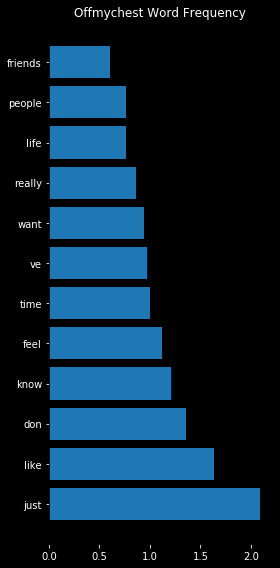

In [166]:

fig = plt.figure(figsize=(4,8), facecolor=(0,0,0))

ax = fig.add_subplot(111)
ax.barh(off_10.index, off_10.values)
ax.patch.set_facecolor('black')
ax.set_title('Offmychest Word Frequency',color= 'white')
ax.tick_params(colors='white')
plt.tight_layout()


### Depressed

In [307]:

x_dep = dep['selftext'] #features
y_dep = dep['subreddit'] #target

In [308]:
cvec = CountVectorizer(stop_words = 'english') 

Z_dep = cvec.fit_transform(x_dep)

In [87]:
dep_vect = pd.DataFrame(Z_dep.todense(), columns=cvec.get_feature_names()).reindex(y_dep.index)

In [88]:
dep_10 = dep_vect.mean().sort_values(ascending=False).iloc[:10]

In [89]:
dep_10.values

array([1.71104742, 1.31765677, 1.18408025, 1.13060188, 0.83300764,
       0.80749522, 0.76548115, 0.75805541, 0.61121244, 0.57571218])

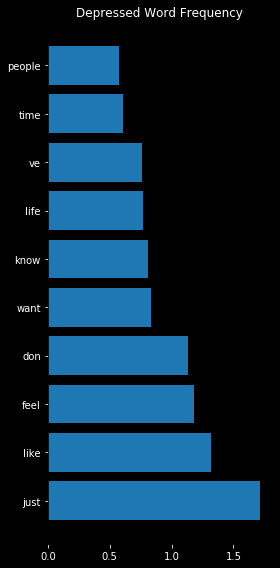

In [169]:

fig = plt.figure(figsize=(4,8), facecolor=(0,0,0))

ax = fig.add_subplot(111)
ax.barh(dep_10.index, dep_10.values)
ax.patch.set_facecolor('black')
ax.set_title('Depressed Word Frequency',color= 'white')
ax.tick_params(colors='white')
plt.tight_layout()


### Conclusion:

In this project, i used multiple estimators and transformers to find which one gives the best results. Overall, Most of the models were overfitted. Adjusting the hyperparameters will help balance the model, but the data is big and requires a lot of time to find that balance.

Regardless, Logistic Regression was the best, it gave around 81 accuracy score. Even though this score is low, the subreddits i choose were very similar in content and the use of words. The baseline model is 50%, so we bet it by 30%. Thats great!

Even though this model can be improved, we can use this model to find users who are depressed on platforms other than reddit. Finding these people and offering them help is very important.